In [124]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets, models 

In [125]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [126]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV2, self).__init__()
        self.features = models.mobilenet_v2(pretrained=False).features
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [128]:
model = MobileNetV2().to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [129]:
best_checkpoint = torch.load('/content/gdrive/MyDrive/AI Project/d1_mnv2_model_checkpoint.pth')
print(best_checkpoint.keys())
model.load_state_dict(best_checkpoint['state_dict'])

dict_keys(['epoch', 'state_dict', 'optimizer', 'train_loss', 'val_loss'])


<All keys matched successfully>

In [130]:
import zipfile
path_to_zip_file = "/content/gdrive/MyDrive/AI Project/file.zip"
directory_to_extract_to = "/content"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [131]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [132]:
output_dir = "/content/kaggle/working/trimmed_dataset"

In [133]:
dataset=datasets.ImageFolder(root=(output_dir),transform=train_transform)
dataset

Dataset ImageFolder
    Number of datapoints: 8000
    Root location: /content/kaggle/working/trimmed_dataset
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [134]:
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [135]:
# Define the dataloaders
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [136]:
model = model.cuda()
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [137]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            #print(model(x)[0])
            #y_pred, _ = model(x)
            y_pred = model(x)[0]

            outputs.append(y_pred.cpu())
            labels.append(y)
    #print(outputs)
    #outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [138]:
outputs, labels = get_representations(model, test_dataloader)

In [139]:
def plot_representations(data, labels, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')

In [140]:
from sklearn import manifold

In [141]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [142]:
new_array = []
for i in outputs:
  x = i.detach().cpu().numpy()
  new_array.append(x)

new_array = np.asarray(new_array)
new_array.shape

(1600, 5)

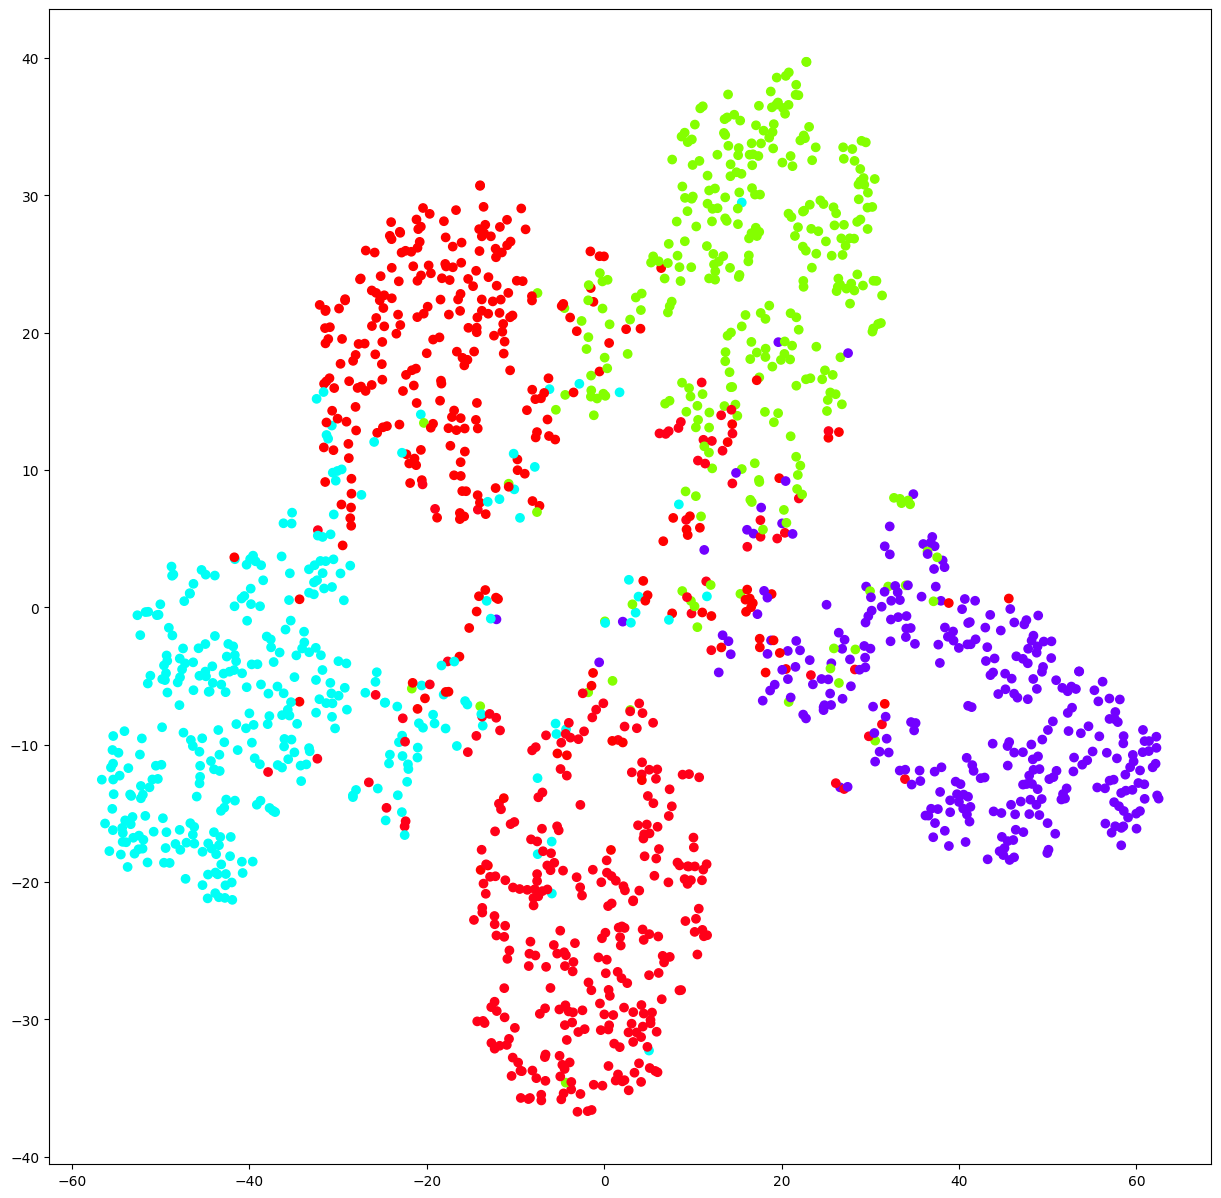

In [143]:
output_tsne_data = get_tsne(new_array)
plot_representations(output_tsne_data, labels)